In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout,LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Raw_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/only data/raw_data.npz'

Theta_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/DWT/Raw/DWT.npz'



# RAW = np.load(Raw_data, allow_pickle=True)  # Allow loading pickled object arrays
# X = RAW['X'].astype('float64')
# Y = RAW['Y'].astype('float64')
# group = RAW['Group'].astype('float64')

This is a good performing model

In [ ]:
# %%capture
# !pip install wandb

In [ ]:
# import wandb

In [ ]:
# !wandb login

# CNN-LSTM

In [ ]:
%%capture
!pip install tensorflow_addons

In [ ]:
import tensorflow_addons as tfa
from keras.optimizers import RMSprop, Adam

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Total/CNN_LSTM/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Total/CNN_LSTM/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [ ]:
global_model, metrics_df = federated_learning(Theta_data)


Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 52, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 18s 66ms/step - loss: 1.8177 - accuracy: 0.5735 - val_loss: 1.8124 - val_accuracy: 0.4860
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 1.8011 - accuracy: 0.6818 - val_loss: 1.8002 - val_accuracy: 0.4817
Epoch 3/100
29/29 [==============================] - 1s 25ms/step - loss: 1.7804 - accuracy: 0.7147 - val_loss: 1.7878 - val_accuracy: 0.6519
Epoch 4/100
29/29 [==============================] - 1s 27ms/step - loss: 1.7508 - accuracy: 0.7400 - val_loss: 1.7750 - val_accuracy: 0.6832
Epoch 5/100
29/29 [==============================] - 1s 31ms/step - loss: 1.7073 - accuracy: 0.7470 - val_loss: 1.7602 - val_accuracy: 0.7220
Epoch 6/100
29/29 [==============================] - 1s 21ms/step - loss: 1.6550 - accuracy: 0.7543 - val_loss: 1.7426 - val_accuracy: 0.7220
Epoch 7/100
29/29 [==============================] - 1s 30ms/step - loss: 1.6024 - accuracy: 0.7627 - val_loss: 1.7197 - val_accuracy: 0.7651
Epoch 8/100
29/29

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 101ms/step - loss: 1.8182 - accuracy: 0.5767 - val_loss: 1.8128 - val_accuracy: 0.6210
Epoch 2/100
28/28 [==============================] - 1s 22ms/step - loss: 1.8030 - accuracy: 0.6848 - val_loss: 1.8009 - val_accuracy: 0.6109
Epoch 3/100
28/28 [==============================] - 1s 33ms/step - loss: 1.7853 - accuracy: 0.7071 - val_loss: 1.7891 - val_accuracy: 0.6459
Epoch 4/100
28/28 [==============================] - 1s 22ms/step - loss: 1.7618 - accuracy: 0.7210 - val_loss: 1.7771 - val_accuracy: 0.6414
Epoch 5/100
28/28 [==============================] - 1s 36ms/step - loss: 1.7292 - accuracy: 0.7323 - val_loss: 1.7637 - val_accuracy: 0.6923
Epoch 6/100
28/28 [==============================] - 1s 30ms/step - loss: 1.6891 - accuracy: 0.7383 - val_loss: 1.7487 - val_accuracy: 0.6934
Epoch 7/100
28/28 [==============================] - 1s 20ms/step - loss: 1.6459 - accuracy: 0.7360 - val_loss: 1.7316 - val_accuracy: 0.6934
Epoch 8/100
28/28

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 76ms/step - loss: 1.8173 - accuracy: 0.5855 - val_loss: 1.8115 - val_accuracy: 0.7314
Epoch 2/100
31/31 [==============================] - 1s 24ms/step - loss: 1.8002 - accuracy: 0.6977 - val_loss: 1.7986 - val_accuracy: 0.5992
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 1.7791 - accuracy: 0.7315 - val_loss: 1.7858 - val_accuracy: 0.5847
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 1.7522 - accuracy: 0.7336 - val_loss: 1.7724 - val_accuracy: 0.6560
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 1.7140 - accuracy: 0.7323 - val_loss: 1.7581 - val_accuracy: 0.6312
Epoch 6/100
31/31 [==============================] - 1s 25ms/step - loss: 1.6649 - accuracy: 0.7488 - val_loss: 1.7395 - val_accuracy: 0.7407
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 1.6130 - accuracy: 0.7501 - val_loss: 1.7197 - val_accuracy: 0.6983
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 60ms/step - loss: 0.9452 - accuracy: 0.8303 - val_loss: 1.2279 - val_accuracy: 0.7629
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 0.9352 - accuracy: 0.8362 - val_loss: 1.2215 - val_accuracy: 0.7317
Epoch 3/100
29/29 [==============================] - 1s 20ms/step - loss: 0.9249 - accuracy: 0.8346 - val_loss: 1.2136 - val_accuracy: 0.7543
Epoch 4/100
29/29 [==============================] - 1s 29ms/step - loss: 0.9161 - accuracy: 0.8427 - val_loss: 1.2056 - val_accuracy: 0.7662
Epoch 5/100
29/29 [==============================] - 1s 33ms/step - loss: 0.9072 - accuracy: 0.8459 - val_loss: 1.1966 - val_accuracy: 0.7737
Epoch 6/100
29/29 [==============================] - 1s 32ms/step - loss: 0.9041 - accuracy: 0.8464 - val_loss: 1.1862 - val_accuracy: 0.7812
Epoch 7/100
29/29 [==============================] - 1s 28ms/step - loss: 0.8999 - accuracy: 0.8424 - val_loss: 1.1755 - val_accuracy: 0.7899
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 80ms/step - loss: 0.9753 - accuracy: 0.8147 - val_loss: 1.2299 - val_accuracy: 0.7489
Epoch 2/100
28/28 [==============================] - 1s 22ms/step - loss: 0.9597 - accuracy: 0.8186 - val_loss: 1.2241 - val_accuracy: 0.7104
Epoch 3/100
28/28 [==============================] - 1s 23ms/step - loss: 0.9490 - accuracy: 0.8277 - val_loss: 1.2166 - val_accuracy: 0.7421
Epoch 4/100
28/28 [==============================] - 1s 21ms/step - loss: 0.9441 - accuracy: 0.8226 - val_loss: 1.2095 - val_accuracy: 0.7262
Epoch 5/100
28/28 [==============================] - 1s 26ms/step - loss: 0.9425 - accuracy: 0.8251 - val_loss: 1.2014 - val_accuracy: 0.7783
Epoch 6/100
28/28 [==============================] - 1s 28ms/step - loss: 0.9295 - accuracy: 0.8234 - val_loss: 1.1923 - val_accuracy: 0.7907
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 0.9245 - accuracy: 0.8333 - val_loss: 1.1841 - val_accuracy: 0.7794
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 76ms/step - loss: 0.9361 - accuracy: 0.8408 - val_loss: 1.2284 - val_accuracy: 0.7159
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 0.9200 - accuracy: 0.8442 - val_loss: 1.2202 - val_accuracy: 0.7231
Epoch 3/100
31/31 [==============================] - 1s 26ms/step - loss: 0.9117 - accuracy: 0.8442 - val_loss: 1.2117 - val_accuracy: 0.7562
Epoch 4/100
31/31 [==============================] - 1s 28ms/step - loss: 0.9055 - accuracy: 0.8439 - val_loss: 1.2025 - val_accuracy: 0.7738
Epoch 5/100
31/31 [==============================] - 1s 26ms/step - loss: 0.8926 - accuracy: 0.8486 - val_loss: 1.1932 - val_accuracy: 0.7748
Epoch 6/100
31/31 [==============================] - 1s 27ms/step - loss: 0.8861 - accuracy: 0.8486 - val_loss: 1.1806 - val_accuracy: 0.8037
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 0.8827 - accuracy: 0.8519 - val_loss: 1.1684 - val_accuracy: 0.7924
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 72ms/step - loss: 0.6052 - accuracy: 0.8925 - val_loss: 1.0128 - val_accuracy: 0.8351
Epoch 2/100
29/29 [==============================] - 1s 17ms/step - loss: 0.5901 - accuracy: 0.9001 - val_loss: 1.0083 - val_accuracy: 0.8147
Epoch 3/100
29/29 [==============================] - 1s 18ms/step - loss: 0.5977 - accuracy: 0.8941 - val_loss: 1.0030 - val_accuracy: 0.8050
Epoch 4/100
29/29 [==============================] - 1s 25ms/step - loss: 0.5861 - accuracy: 0.9054 - val_loss: 0.9964 - val_accuracy: 0.8362
Epoch 5/100
29/29 [==============================] - 1s 20ms/step - loss: 0.5840 - accuracy: 0.9022 - val_loss: 0.9886 - val_accuracy: 0.8319
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 0.5717 - accuracy: 0.9084 - val_loss: 0.9825 - val_accuracy: 0.8341
Epoch 7/100
29/29 [==============================] - 1s 20ms/step - loss: 0.5713 - accuracy: 0.9071 - val_loss: 0.9702 - val_accuracy: 0.8319
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 63ms/step - loss: 0.6272 - accuracy: 0.8837 - val_loss: 1.0155 - val_accuracy: 0.7805
Epoch 2/100
28/28 [==============================] - 1s 26ms/step - loss: 0.6231 - accuracy: 0.8795 - val_loss: 1.0110 - val_accuracy: 0.8292
Epoch 3/100
28/28 [==============================] - 1s 18ms/step - loss: 0.6104 - accuracy: 0.8928 - val_loss: 1.0063 - val_accuracy: 0.8077
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6101 - accuracy: 0.8882 - val_loss: 1.0013 - val_accuracy: 0.8043
Epoch 5/100
28/28 [==============================] - 0s 18ms/step - loss: 0.6154 - accuracy: 0.8888 - val_loss: 0.9948 - val_accuracy: 0.8224
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 0.6048 - accuracy: 0.8939 - val_loss: 0.9891 - val_accuracy: 0.7941
Epoch 7/100
28/28 [==============================] - 1s 26ms/step - loss: 0.6076 - accuracy: 0.8891 - val_loss: 0.9792 - val_accuracy: 0.8326
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 56ms/step - loss: 0.5953 - accuracy: 0.8972 - val_loss: 1.0126 - val_accuracy: 0.8233
Epoch 2/100
31/31 [==============================] - 1s 28ms/step - loss: 0.5919 - accuracy: 0.9000 - val_loss: 1.0072 - val_accuracy: 0.8337
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.5878 - accuracy: 0.9000 - val_loss: 1.0012 - val_accuracy: 0.8254
Epoch 4/100
31/31 [==============================] - 1s 26ms/step - loss: 0.5791 - accuracy: 0.9065 - val_loss: 0.9943 - val_accuracy: 0.8368
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.5792 - accuracy: 0.9031 - val_loss: 0.9871 - val_accuracy: 0.8171
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 0.5733 - accuracy: 0.9036 - val_loss: 0.9783 - val_accuracy: 0.8347
Epoch 7/100
31/31 [==============================] - 1s 26ms/step - loss: 0.5703 - accuracy: 0.9054 - val_loss: 0.9672 - val_accuracy: 0.8388
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 75ms/step - loss: 0.4514 - accuracy: 0.9340 - val_loss: 0.9312 - val_accuracy: 0.8491
Epoch 2/100
29/29 [==============================] - 1s 21ms/step - loss: 0.4369 - accuracy: 0.9367 - val_loss: 0.9282 - val_accuracy: 0.8276
Epoch 3/100
29/29 [==============================] - 1s 32ms/step - loss: 0.4459 - accuracy: 0.9340 - val_loss: 0.9222 - val_accuracy: 0.8513
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.4266 - accuracy: 0.9450 - val_loss: 0.9172 - val_accuracy: 0.8416
Epoch 5/100
29/29 [==============================] - 1s 20ms/step - loss: 0.4262 - accuracy: 0.9423 - val_loss: 0.9081 - val_accuracy: 0.8491
Epoch 6/100
29/29 [==============================] - 1s 20ms/step - loss: 0.4310 - accuracy: 0.9388 - val_loss: 0.9011 - val_accuracy: 0.8373
Epoch 7/100
29/29 [==============================] - 1s 37ms/step - loss: 0.4167 - accuracy: 0.9480 - val_loss: 0.8871 - val_accuracy: 0.8534
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 92ms/step - loss: 0.4593 - accuracy: 0.9281 - val_loss: 0.9334 - val_accuracy: 0.8371
Epoch 2/100
28/28 [==============================] - 1s 22ms/step - loss: 0.4431 - accuracy: 0.9372 - val_loss: 0.9298 - val_accuracy: 0.8348
Epoch 3/100
28/28 [==============================] - 1s 18ms/step - loss: 0.4357 - accuracy: 0.9372 - val_loss: 0.9246 - val_accuracy: 0.8281
Epoch 4/100
28/28 [==============================] - 1s 18ms/step - loss: 0.4373 - accuracy: 0.9366 - val_loss: 0.9197 - val_accuracy: 0.8303
Epoch 5/100
28/28 [==============================] - 1s 18ms/step - loss: 0.4307 - accuracy: 0.9360 - val_loss: 0.9137 - val_accuracy: 0.8269
Epoch 6/100
28/28 [==============================] - 1s 26ms/step - loss: 0.4237 - accuracy: 0.9440 - val_loss: 0.9038 - val_accuracy: 0.8416
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 0.4236 - accuracy: 0.9448 - val_loss: 0.8938 - val_accuracy: 0.8303
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 56ms/step - loss: 0.4668 - accuracy: 0.9258 - val_loss: 0.9310 - val_accuracy: 0.8523
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4302 - accuracy: 0.9401 - val_loss: 0.9256 - val_accuracy: 0.8450
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4250 - accuracy: 0.9437 - val_loss: 0.9201 - val_accuracy: 0.8450
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4273 - accuracy: 0.9395 - val_loss: 0.9120 - val_accuracy: 0.8450
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4227 - accuracy: 0.9437 - val_loss: 0.9043 - val_accuracy: 0.8388
Epoch 6/100
31/31 [==============================] - 1s 25ms/step - loss: 0.4176 - accuracy: 0.9465 - val_loss: 0.8930 - val_accuracy: 0.8543
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 0.4189 - accuracy: 0.9452 - val_loss: 0.8776 - val_accuracy: 0.8450
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 84ms/step - loss: 0.3632 - accuracy: 0.9561 - val_loss: 0.8865 - val_accuracy: 0.8621
Epoch 2/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3481 - accuracy: 0.9585 - val_loss: 0.8831 - val_accuracy: 0.8513
Epoch 3/100
29/29 [==============================] - 1s 22ms/step - loss: 0.3255 - accuracy: 0.9696 - val_loss: 0.8765 - val_accuracy: 0.8578
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 0.3311 - accuracy: 0.9634 - val_loss: 0.8666 - val_accuracy: 0.8567
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.3242 - accuracy: 0.9688 - val_loss: 0.8601 - val_accuracy: 0.8459
Epoch 6/100
29/29 [==============================] - 1s 17ms/step - loss: 0.3111 - accuracy: 0.9709 - val_loss: 0.8479 - val_accuracy: 0.8567
Epoch 7/100
29/29 [==============================] - 1s 17ms/step - loss: 0.3140 - accuracy: 0.9706 - val_loss: 0.8340 - val_accuracy: 0.8438
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 60ms/step - loss: 0.3908 - accuracy: 0.9440 - val_loss: 0.8900 - val_accuracy: 0.8213
Epoch 2/100
28/28 [==============================] - 1s 27ms/step - loss: 0.3409 - accuracy: 0.9621 - val_loss: 0.8860 - val_accuracy: 0.8371
Epoch 3/100
28/28 [==============================] - 1s 31ms/step - loss: 0.3258 - accuracy: 0.9655 - val_loss: 0.8800 - val_accuracy: 0.8382
Epoch 4/100
28/28 [==============================] - 1s 18ms/step - loss: 0.3182 - accuracy: 0.9675 - val_loss: 0.8719 - val_accuracy: 0.8326
Epoch 5/100
28/28 [==============================] - 1s 18ms/step - loss: 0.3309 - accuracy: 0.9646 - val_loss: 0.8632 - val_accuracy: 0.8382
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.3197 - accuracy: 0.9680 - val_loss: 0.8550 - val_accuracy: 0.8314
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 0.3337 - accuracy: 0.9604 - val_loss: 0.8413 - val_accuracy: 0.8247
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 62ms/step - loss: 0.3542 - accuracy: 0.9537 - val_loss: 0.8857 - val_accuracy: 0.8523
Epoch 2/100
31/31 [==============================] - 1s 28ms/step - loss: 0.3321 - accuracy: 0.9615 - val_loss: 0.8805 - val_accuracy: 0.8554
Epoch 3/100
31/31 [==============================] - 1s 29ms/step - loss: 0.3403 - accuracy: 0.9618 - val_loss: 0.8727 - val_accuracy: 0.8616
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 0.3342 - accuracy: 0.9612 - val_loss: 0.8649 - val_accuracy: 0.8223
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 0.3219 - accuracy: 0.9667 - val_loss: 0.8541 - val_accuracy: 0.8502
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 0.3226 - accuracy: 0.9656 - val_loss: 0.8399 - val_accuracy: 0.8595
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 0.3205 - accuracy: 0.9693 - val_loss: 0.8251 - val_accuracy: 0.8471
Epoch 8/100
31/31 

In [ ]:

metrics_df.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.750,0.759,0.734,0.746,0.734,0.767,0.501
1,1,0.785,0.783,0.787,0.785,0.787,0.782,0.569
2,2,0.724,0.717,0.739,0.728,0.739,0.709,0.448
3,0,0.778,0.782,0.771,0.776,0.771,0.786,0.556
4,1,0.823,0.824,0.822,0.823,0.822,0.825,0.647
5,2,0.733,0.713,0.779,0.745,0.779,0.687,0.466
6,0,0.798,0.826,0.755,0.789,0.755,0.841,0.596
7,1,0.854,0.860,0.845,0.852,0.845,0.863,0.708
8,2,0.770,0.759,0.791,0.775,0.791,0.749,0.540
9,0,0.808,0.815,0.797,0.806,0.797,0.819,0.616


In [ ]:
metrics_df.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/DWT/CNN_LSTM/DWT_CNN_LSTM.csv', index = False)

#Draw CNN_LSTM

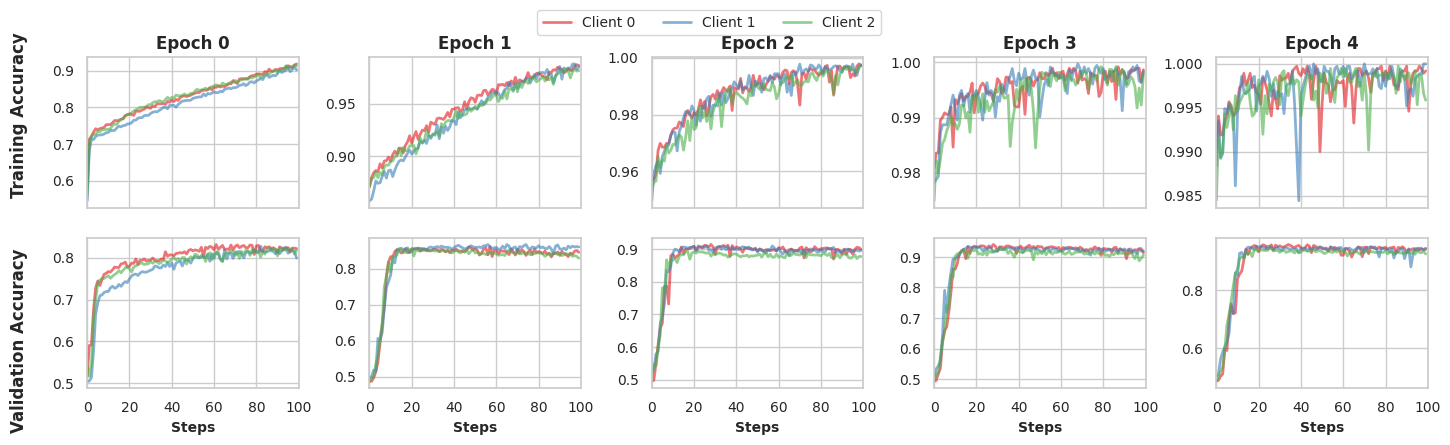

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Function to read CSV logs and extract accuracy and validation accuracy
def read_logs(log_dir, num_clients, local_epochs):
    dataframes = []
    for epoch in range(local_epochs):
        for client in range(num_clients):
            log_file = os.path.join(log_dir, f'training_log_epoch_{epoch}_client_{client}.csv')
            if os.path.exists(log_file):
                df = pd.read_csv(log_file, sep=';')
                df['epoch_number'] = epoch
                df['client_number'] = client
                dataframes.append(df)
            else:
                print(f"Log file not found: {log_file}")

    return pd.concat(dataframes) if dataframes else pd.DataFrame()

# Function to plot the training and validation accuracy
def plot_accuracy(all_metrics_df, unique_epochs, output_dir):
    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Create subplots for each epoch
    fig, axes = plt.subplots(2, len(unique_epochs), figsize=(len(unique_epochs) * 3, 4.5), sharex=True)

    # Set the color palette
    palette = sns.color_palette("Set1", n_colors=all_metrics_df['client_number'].nunique())

    # Store the lines and labels for the legend
    lines = []
    labels = []

    # Iterate through each epoch and plot the training and validation accuracy
    for i, epoch in enumerate(unique_epochs):
        epoch_df = all_metrics_df[all_metrics_df['epoch_number'] == epoch]
        for j, client in enumerate(epoch_df['client_number'].unique()):
            client_df = epoch_df[epoch_df['client_number'] == client].dropna(subset=['accuracy', 'val_accuracy'])
            if not client_df.empty:
                line, = axes[0, i].plot(client_df.index, client_df['accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)
                axes[1, i].plot(client_df.index, client_df['val_accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)

                if i == 0:
                    lines.append(line)
                    labels.append(f'Client {client}')

        axes[0, i].set_title(f'Epoch {epoch}', fontsize=12, fontweight='bold')
        axes[0, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
        axes[1, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
        axes[1, i].set_xlabel('Steps', fontsize=10, fontweight='bold')
        axes[0, i].grid(True)
        axes[1, i].grid(True)
        axes[0, i].tick_params(axis='both', which='major', labelsize=10)
        axes[1, i].tick_params(axis='both', which='major', labelsize=10)

    # Add a single legend for the entire figure
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fontsize=10, frameon=True)

    # Add row labels
    fig.text(0.04, 0.75, 'Training Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')
    fig.text(0.04, 0.25, 'Validation Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')

    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.2, top=0.88)  # Add some space between the rows and reduce space between the legend and plot

    # Save the figure in high DPI PNG and PDF
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig.savefig(os.path.join(output_dir, 'accuracy_plot.png'), dpi=300, format='png')
    fig.savefig(os.path.join(output_dir, 'accuracy_plot.pdf'), dpi=300, format='pdf')

    plt.show()

# Directory where CSV logs are saved
log_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total'

# Output directory for saving plots
output_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/plots'

# Number of clients and local epochs
num_clients = 3
local_epochs = 5

# Read logs and generate the dataframe
all_metrics_df = read_logs(log_dir, num_clients, local_epochs)

# Get unique epochs from the dataframe
unique_epochs = sorted(all_metrics_df['epoch_number'].unique())

# Plot the accuracy
plot_accuracy(all_metrics_df, unique_epochs, output_dir)


Final Epoch: 4
Average Training Accuracy: 0.9972
Average Validation Accuracy: 0.9058


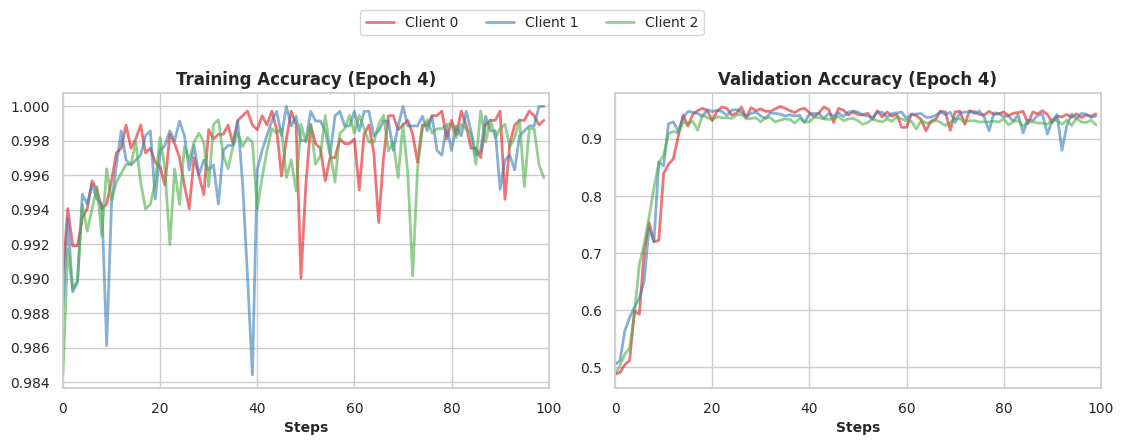

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Function to read CSV logs and extract accuracy and validation accuracy
def read_logs(log_dir, num_clients, local_epochs):
    dataframes = []
    for epoch in range(local_epochs):
        for client in range(num_clients):
            log_file = os.path.join(log_dir, f'training_log_epoch_{epoch}_client_{client}.csv')
            if os.path.exists(log_file):
                df = pd.read_csv(log_file, sep=';')
                df['epoch_number'] = epoch
                df['client_number'] = client
                dataframes.append(df)
            else:
                print(f"Log file not found: {log_file}")

    return pd.concat(dataframes) if dataframes else pd.DataFrame()

# Function to plot the training and validation accuracy for the final epoch
def plot_final_epoch_accuracy(all_metrics_df, output_dir):
    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Get the final epoch number
    final_epoch = all_metrics_df['epoch_number'].max()

    # Filter the data for the final epoch
    final_epoch_df = all_metrics_df[all_metrics_df['epoch_number'] == final_epoch]

    # Calculate the average training and validation accuracy for the final epoch
    avg_train_accuracy = final_epoch_df['accuracy'].mean()
    avg_val_accuracy = final_epoch_df['val_accuracy'].mean()

    print(f"Final Epoch: {final_epoch}")
    print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
    print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")

    # Create subplots for the final epoch
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

    # Set the color palette
    palette = sns.color_palette("Set1", n_colors=final_epoch_df['client_number'].nunique())

    # Store the lines and labels for the legend
    lines = []
    labels = []

    # Plot the training and validation accuracy for the final epoch
    for client in final_epoch_df['client_number'].unique():
        client_df = final_epoch_df[final_epoch_df['client_number'] == client].dropna(subset=['accuracy', 'val_accuracy'])
        if not client_df.empty:
            line, = axes[0].plot(client_df.index, client_df['accuracy'], label=f'Client {client}', alpha=0.6, color=palette[client], linewidth=2.0)
            axes[1].plot(client_df.index, client_df['val_accuracy'], label=f'Client {client}', alpha=0.6, color=palette[client], linewidth=2.0)

            if len(lines) < final_epoch_df['client_number'].nunique():
                lines.append(line)
                labels.append(f'Client {client}')

    axes[0].set_title(f'Training Accuracy (Epoch {final_epoch})', fontsize=12, fontweight='bold')
    axes[0].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps

    axes[1].set_title(f'Validation Accuracy (Epoch {final_epoch})', fontsize=12, fontweight='bold')


    for ax in axes:
        ax.set_xlabel('Steps', fontsize=10, fontweight='bold')
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a single legend for the entire figure
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize=10, frameon=True)

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.subplots_adjust(hspace=0.2, top=0.85)  # Add some space between the rows and reduce space between the legend and plot

    # Save the figure in high DPI PNG and PDF
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig.savefig(os.path.join(output_dir, 'final_epoch_accuracy_plot.png'), dpi=300, format='png')
    fig.savefig(os.path.join(output_dir, 'final_epoch_accuracy_plot.pdf'), dpi=300, format='pdf')

    plt.show()

# Directory where CSV logs are saved
log_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total'

# Output directory for saving plots
output_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/plots'

# Number of clients and local epochs
num_clients = 3
local_epochs = 5

# Read logs and generate the dataframe
all_metrics_df = read_logs(log_dir, num_clients, local_epochs)

# Plot the accuracy for the final epoch
plot_final_epoch_accuracy(all_metrics_df, output_dir)


# CNN

In [ ]:
%%capture
!pip install tensorflow_addons

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Total/CNN/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Total/CNN/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
global_model_CNN, metrics_df_CNN = federated_learning(Theta_data)

Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 52, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 16s 49ms/step - loss: 1.9778 - accuracy: 0.6309 - val_loss: 2.0025 - val_accuracy: 0.7134
Epoch 2/100
29/29 [==============================] - 1s 23ms/step - loss: 1.9012 - accuracy: 0.7519 - val_loss: 1.9793 - val_accuracy: 0.7608
Epoch 3/100
29/29 [==============================] - 0s 14ms/step - loss: 1.8428 - accuracy: 0.7600 - val_loss: 1.9543 - val_accuracy: 0.7575
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 1.7917 - accuracy: 0.7686 - val_loss: 1.9291 - val_accuracy: 0.7683
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 1.7530 - accuracy: 0.7707 - val_loss: 1.9056 - val_accuracy: 0.7694
Epoch 6/100
29/29 [==============================] - 1s 24ms/step - loss: 1.7197 - accuracy: 0.7804 - val_loss: 1.8804 - val_accuracy: 0.7716
Epoch 7/100
29/29 [==============================] - 1s 23ms/step - loss: 1.6921 - accuracy: 0.7842 - val_loss: 1.8563 - val_accuracy: 0.7759
Epoch 8/100
29/29

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 5s 63ms/step - loss: 1.9850 - accuracy: 0.6214 - val_loss: 2.0041 - val_accuracy: 0.6787
Epoch 2/100
28/28 [==============================] - 1s 23ms/step - loss: 1.9203 - accuracy: 0.7326 - val_loss: 1.9823 - val_accuracy: 0.7410
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 1.8700 - accuracy: 0.7419 - val_loss: 1.9600 - val_accuracy: 0.7172
Epoch 4/100
28/28 [==============================] - 1s 23ms/step - loss: 1.8259 - accuracy: 0.7439 - val_loss: 1.9384 - val_accuracy: 0.7557
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 1.7862 - accuracy: 0.7518 - val_loss: 1.9165 - val_accuracy: 0.7545
Epoch 6/100
28/28 [==============================] - 1s 23ms/step - loss: 1.7487 - accuracy: 0.7595 - val_loss: 1.8934 - val_accuracy: 0.7602
Epoch 7/100
28/28 [==============================] - 1s 25ms/step - loss: 1.7176 - accuracy: 0.7649 - val_loss: 1.8721 - val_accuracy: 0.7726
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 4s 51ms/step - loss: 1.9830 - accuracy: 0.6271 - val_loss: 2.0021 - val_accuracy: 0.6890
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 1.9112 - accuracy: 0.7455 - val_loss: 1.9787 - val_accuracy: 0.7562
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 1.8527 - accuracy: 0.7643 - val_loss: 1.9536 - val_accuracy: 0.7572
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 1.7982 - accuracy: 0.7680 - val_loss: 1.9300 - val_accuracy: 0.7510
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 1.7511 - accuracy: 0.7819 - val_loss: 1.9014 - val_accuracy: 0.7645
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 1.7132 - accuracy: 0.7809 - val_loss: 1.8754 - val_accuracy: 0.7717
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 1.6757 - accuracy: 0.8008 - val_loss: 1.8462 - val_accuracy: 0.7686
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 5s 34ms/step - loss: 0.8431 - accuracy: 0.8621 - val_loss: 1.1707 - val_accuracy: 0.8330
Epoch 2/100
29/29 [==============================] - 0s 14ms/step - loss: 0.8310 - accuracy: 0.8683 - val_loss: 1.1611 - val_accuracy: 0.8287
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.8231 - accuracy: 0.8648 - val_loss: 1.1481 - val_accuracy: 0.8222
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 0.8104 - accuracy: 0.8737 - val_loss: 1.1366 - val_accuracy: 0.8351
Epoch 5/100
29/29 [==============================] - 0s 15ms/step - loss: 0.8045 - accuracy: 0.8745 - val_loss: 1.1296 - val_accuracy: 0.8319
Epoch 6/100
29/29 [==============================] - 1s 23ms/step - loss: 0.7968 - accuracy: 0.8825 - val_loss: 1.1130 - val_accuracy: 0.8384
Epoch 7/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7931 - accuracy: 0.8812 - val_loss: 1.0956 - val_accuracy: 0.8341
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 4s 37ms/step - loss: 0.8697 - accuracy: 0.8497 - val_loss: 1.1754 - val_accuracy: 0.8122
Epoch 2/100
28/28 [==============================] - 1s 26ms/step - loss: 0.8511 - accuracy: 0.8568 - val_loss: 1.1662 - val_accuracy: 0.8224
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 0.8375 - accuracy: 0.8596 - val_loss: 1.1569 - val_accuracy: 0.8179
Epoch 4/100
28/28 [==============================] - 1s 25ms/step - loss: 0.8283 - accuracy: 0.8656 - val_loss: 1.1478 - val_accuracy: 0.8133
Epoch 5/100
28/28 [==============================] - 1s 36ms/step - loss: 0.8320 - accuracy: 0.8563 - val_loss: 1.1367 - val_accuracy: 0.8281
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.8198 - accuracy: 0.8599 - val_loss: 1.1228 - val_accuracy: 0.8032
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 0.8153 - accuracy: 0.8613 - val_loss: 1.1105 - val_accuracy: 0.8201
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 5s 36ms/step - loss: 0.8409 - accuracy: 0.8651 - val_loss: 1.1676 - val_accuracy: 0.7965
Epoch 2/100
31/31 [==============================] - 1s 24ms/step - loss: 0.8210 - accuracy: 0.8760 - val_loss: 1.1589 - val_accuracy: 0.8285
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 0.8147 - accuracy: 0.8780 - val_loss: 1.1449 - val_accuracy: 0.8151
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.8048 - accuracy: 0.8791 - val_loss: 1.1341 - val_accuracy: 0.8264
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 0.8003 - accuracy: 0.8824 - val_loss: 1.1200 - val_accuracy: 0.8254
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 0.7911 - accuracy: 0.8814 - val_loss: 1.1073 - val_accuracy: 0.8161
Epoch 7/100
31/31 [==============================] - 0s 15ms/step - loss: 0.7832 - accuracy: 0.8886 - val_loss: 1.0874 - val_accuracy: 0.8161
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 4s 42ms/step - loss: 0.5873 - accuracy: 0.9176 - val_loss: 1.0062 - val_accuracy: 0.8545
Epoch 2/100
29/29 [==============================] - 1s 19ms/step - loss: 0.5475 - accuracy: 0.9337 - val_loss: 0.9987 - val_accuracy: 0.8524
Epoch 3/100
29/29 [==============================] - 1s 23ms/step - loss: 0.5388 - accuracy: 0.9402 - val_loss: 0.9868 - val_accuracy: 0.8491
Epoch 4/100
29/29 [==============================] - 0s 16ms/step - loss: 0.5444 - accuracy: 0.9410 - val_loss: 0.9796 - val_accuracy: 0.8438
Epoch 5/100
29/29 [==============================] - 0s 15ms/step - loss: 0.5387 - accuracy: 0.9397 - val_loss: 0.9675 - val_accuracy: 0.8308
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 0.5426 - accuracy: 0.9407 - val_loss: 0.9606 - val_accuracy: 0.8028
Epoch 7/100
29/29 [==============================] - 0s 14ms/step - loss: 0.5345 - accuracy: 0.9432 - val_loss: 0.9294 - val_accuracy: 0.8481
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 23ms/step - loss: 0.5643 - accuracy: 0.9281 - val_loss: 1.0079 - val_accuracy: 0.8179
Epoch 3/100
28/28 [==============================] - 1s 24ms/step - loss: 0.5538 - accuracy: 0.9341 - val_loss: 0.9969 - val_accuracy: 0.8224
Epoch 4/100
28/28 [==============================] - 0s 17ms/step - loss: 0.5482 - accuracy: 0.9355 - val_loss: 0.9873 - val_accuracy: 0.8179
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.5439 - accuracy: 0.9420 - val_loss: 0.9712 - val_accuracy: 0.8213
Epoch 6/100
28/28 [==============================] - 1s 25ms/step - loss: 0.5486 - accuracy: 0.9369 - val_loss: 0.9578 - val_accuracy: 0.8235
Epoch 7/100
28/28 [==============================] - 0s 16ms/step - loss: 0.5393 - accuracy: 0.9386 - val_loss: 0.9462 - val_accuracy: 0.8145
Epoch 8/100
28/28 [==============================] - 0s 15ms/step - loss: 0.5459 - accuracy: 0.9324 - val_loss: 0.9209 - val_accuracy: 0.8213
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
31/31 [==============================] - 1s 29ms/step - loss: 0.5532 - accuracy: 0.9380 - val_loss: 0.9999 - val_accuracy: 0.8430
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 0.5487 - accuracy: 0.9413 - val_loss: 0.9862 - val_accuracy: 0.8481
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.5446 - accuracy: 0.9382 - val_loss: 0.9690 - val_accuracy: 0.8440
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.5395 - accuracy: 0.9424 - val_loss: 0.9541 - val_accuracy: 0.8409
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 0.5332 - accuracy: 0.9460 - val_loss: 0.9440 - val_accuracy: 0.8347
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 0.5324 - accuracy: 0.9452 - val_loss: 0.9166 - val_accuracy: 0.8388
Epoch 8/100
31/31 [==============================] - 0s 16ms/step - loss: 0.5328 - accuracy: 0.9447 - val_loss: 0.9019 - val_accuracy: 0.8461
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 3s 33ms/step - loss: 0.4581 - accuracy: 0.9491 - val_loss: 0.9283 - val_accuracy: 0.8459
Epoch 2/100
29/29 [==============================] - 0s 14ms/step - loss: 0.4158 - accuracy: 0.9725 - val_loss: 0.9289 - val_accuracy: 0.8060
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.4053 - accuracy: 0.9793 - val_loss: 0.9158 - val_accuracy: 0.8114
Epoch 4/100
29/29 [==============================] - 0s 14ms/step - loss: 0.4011 - accuracy: 0.9817 - val_loss: 0.8887 - val_accuracy: 0.8362
Epoch 5/100
29/29 [==============================] - 0s 15ms/step - loss: 0.4011 - accuracy: 0.9795 - val_loss: 0.8821 - val_accuracy: 0.8276
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3921 - accuracy: 0.9863 - val_loss: 0.8560 - val_accuracy: 0.8373
Epoch 7/100
29/29 [==============================] - 0s 14ms/step - loss: 0.3894 - accuracy: 0.9857 - val_loss: 0.8510 - val_accuracy: 0.8244
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 5s 39ms/step - loss: 0.4489 - accuracy: 0.9576 - val_loss: 0.9417 - val_accuracy: 0.8133
Epoch 2/100
28/28 [==============================] - 1s 25ms/step - loss: 0.4142 - accuracy: 0.9745 - val_loss: 0.9269 - val_accuracy: 0.8201
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 0.4089 - accuracy: 0.9762 - val_loss: 0.9169 - val_accuracy: 0.8201
Epoch 4/100
28/28 [==============================] - 1s 23ms/step - loss: 0.4078 - accuracy: 0.9748 - val_loss: 0.9019 - val_accuracy: 0.8213
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.4053 - accuracy: 0.9782 - val_loss: 0.8991 - val_accuracy: 0.8043
Epoch 6/100
28/28 [==============================] - 1s 25ms/step - loss: 0.4055 - accuracy: 0.9776 - val_loss: 0.8734 - val_accuracy: 0.8269
Epoch 7/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3969 - accuracy: 0.9825 - val_loss: 0.8675 - val_accuracy: 0.8054
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 4s 34ms/step - loss: 0.4697 - accuracy: 0.9491 - val_loss: 0.9341 - val_accuracy: 0.8316
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 0.4184 - accuracy: 0.9718 - val_loss: 0.9189 - val_accuracy: 0.8326
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 0.4243 - accuracy: 0.9672 - val_loss: 0.9075 - val_accuracy: 0.8275
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.4090 - accuracy: 0.9739 - val_loss: 0.8918 - val_accuracy: 0.8254
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.4109 - accuracy: 0.9744 - val_loss: 0.8807 - val_accuracy: 0.8140
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 0.4037 - accuracy: 0.9780 - val_loss: 0.8571 - val_accuracy: 0.8192
Epoch 7/100
31/31 [==============================] - 0s 15ms/step - loss: 0.3980 - accuracy: 0.9814 - val_loss: 0.8346 - val_accuracy: 0.8244
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 5s 34ms/step - loss: 0.3848 - accuracy: 0.9679 - val_loss: 0.8755 - val_accuracy: 0.8254
Epoch 2/100
29/29 [==============================] - 1s 24ms/step - loss: 0.3391 - accuracy: 0.9871 - val_loss: 0.8576 - val_accuracy: 0.8394
Epoch 3/100
29/29 [==============================] - 0s 14ms/step - loss: 0.3373 - accuracy: 0.9892 - val_loss: 0.8621 - val_accuracy: 0.7963
Epoch 4/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3264 - accuracy: 0.9925 - val_loss: 0.8336 - val_accuracy: 0.8287
Epoch 5/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3241 - accuracy: 0.9922 - val_loss: 0.8151 - val_accuracy: 0.8308
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3226 - accuracy: 0.9943 - val_loss: 0.7977 - val_accuracy: 0.8341
Epoch 7/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3196 - accuracy: 0.9957 - val_loss: 0.7806 - val_accuracy: 0.8276
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 3s 36ms/step - loss: 0.3753 - accuracy: 0.9711 - val_loss: 0.8732 - val_accuracy: 0.8450
Epoch 2/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3358 - accuracy: 0.9884 - val_loss: 0.8655 - val_accuracy: 0.8247
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 0.3316 - accuracy: 0.9921 - val_loss: 0.8555 - val_accuracy: 0.8224
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3323 - accuracy: 0.9904 - val_loss: 0.8359 - val_accuracy: 0.8337
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3283 - accuracy: 0.9918 - val_loss: 0.8243 - val_accuracy: 0.8281
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.3218 - accuracy: 0.9958 - val_loss: 0.8133 - val_accuracy: 0.8281
Epoch 7/100
28/28 [==============================] - 0s 18ms/step - loss: 0.3202 - accuracy: 0.9969 - val_loss: 0.7893 - val_accuracy: 0.8348
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 4s 39ms/step - loss: 0.3806 - accuracy: 0.9713 - val_loss: 0.8727 - val_accuracy: 0.8378
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.3398 - accuracy: 0.9866 - val_loss: 0.8704 - val_accuracy: 0.8151
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 0.3347 - accuracy: 0.9881 - val_loss: 0.8495 - val_accuracy: 0.8223
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.3285 - accuracy: 0.9920 - val_loss: 0.8258 - val_accuracy: 0.8337
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.3274 - accuracy: 0.9925 - val_loss: 0.8189 - val_accuracy: 0.8120
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 0.3236 - accuracy: 0.9938 - val_loss: 0.7955 - val_accuracy: 0.8151
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 0.3212 - accuracy: 0.9959 - val_loss: 0.7646 - val_accuracy: 0.8337
Epoch 8/100
31/31 

In [ ]:
metrics_df_CNN.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.758,0.751,0.772,0.761,0.772,0.744,0.516
1,1,0.785,0.810,0.743,0.775,0.743,0.826,0.569
2,2,0.722,0.693,0.797,0.741,0.797,0.647,0.444
3,0,0.771,0.780,0.755,0.768,0.755,0.787,0.543
4,1,0.828,0.837,0.814,0.825,0.814,0.842,0.655
5,2,0.754,0.724,0.821,0.770,0.821,0.687,0.508
6,0,0.816,0.828,0.797,0.812,0.797,0.834,0.631
7,1,0.845,0.842,0.850,0.846,0.850,0.840,0.691
8,2,0.801,0.778,0.843,0.809,0.843,0.759,0.602
9,0,0.842,0.851,0.829,0.840,0.829,0.854,0.683


In [ ]:
metrics_df_CNN.round(4).to_csv('//content/drive/MyDrive/EEG Signal /results/FLresults/DWT/CNN/DWT_CNN.csv', index = False)

# GRU

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model_gru(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning_gru(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model_gru(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model_gru(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Total/CNN_GRU/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Total/CNN_GRU/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [ ]:
global_model_gru, metrics_df_gru = federated_learning_gru(Theta_data)

Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 52, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 53ms/step - loss: 1.8128 - accuracy: 0.5929 - val_loss: 1.8115 - val_accuracy: 0.7101
Epoch 2/100
29/29 [==============================] - 1s 24ms/step - loss: 1.7871 - accuracy: 0.7029 - val_loss: 1.7997 - val_accuracy: 0.7575
Epoch 3/100
29/29 [==============================] - 1s 25ms/step - loss: 1.7473 - accuracy: 0.7322 - val_loss: 1.7862 - val_accuracy: 0.7640
Epoch 4/100
29/29 [==============================] - 1s 17ms/step - loss: 1.6995 - accuracy: 0.7478 - val_loss: 1.7702 - val_accuracy: 0.7489
Epoch 5/100
29/29 [==============================] - 0s 16ms/step - loss: 1.6510 - accuracy: 0.7476 - val_loss: 1.7516 - val_accuracy: 0.7425
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 1.6099 - accuracy: 0.7592 - val_loss: 1.7297 - val_accuracy: 0.7511
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 1.5805 - accuracy: 0.7597 - val_loss: 1.7073 - val_accuracy: 0.7619
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 59ms/step - loss: 1.8154 - accuracy: 0.5724 - val_loss: 1.8121 - val_accuracy: 0.6889
Epoch 2/100
28/28 [==============================] - 1s 26ms/step - loss: 1.7941 - accuracy: 0.6800 - val_loss: 1.8012 - val_accuracy: 0.7319
Epoch 3/100
28/28 [==============================] - 1s 18ms/step - loss: 1.7642 - accuracy: 0.7105 - val_loss: 1.7894 - val_accuracy: 0.7217
Epoch 4/100
28/28 [==============================] - 0s 18ms/step - loss: 1.7262 - accuracy: 0.7292 - val_loss: 1.7759 - val_accuracy: 0.7229
Epoch 5/100
28/28 [==============================] - 1s 19ms/step - loss: 1.6830 - accuracy: 0.7388 - val_loss: 1.7603 - val_accuracy: 0.7104
Epoch 6/100
28/28 [==============================] - 1s 27ms/step - loss: 1.6461 - accuracy: 0.7402 - val_loss: 1.7418 - val_accuracy: 0.7330
Epoch 7/100
28/28 [==============================] - 1s 29ms/step - loss: 1.6155 - accuracy: 0.7428 - val_loss: 1.7223 - val_accuracy: 0.7410
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 56ms/step - loss: 1.8136 - accuracy: 0.5990 - val_loss: 1.8108 - val_accuracy: 0.7355
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 1.7883 - accuracy: 0.7067 - val_loss: 1.7988 - val_accuracy: 0.7324
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 1.7533 - accuracy: 0.7253 - val_loss: 1.7856 - val_accuracy: 0.7490
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 1.7098 - accuracy: 0.7416 - val_loss: 1.7705 - val_accuracy: 0.6983
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 1.6610 - accuracy: 0.7395 - val_loss: 1.7509 - val_accuracy: 0.7541
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 1.6186 - accuracy: 0.7527 - val_loss: 1.7286 - val_accuracy: 0.7417
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 1.5803 - accuracy: 0.7649 - val_loss: 1.7056 - val_accuracy: 0.7417
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 58ms/step - loss: 0.9667 - accuracy: 0.8354 - val_loss: 1.2555 - val_accuracy: 0.7705
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 0.9520 - accuracy: 0.8505 - val_loss: 1.2484 - val_accuracy: 0.7058
Epoch 3/100
29/29 [==============================] - 0s 17ms/step - loss: 0.9396 - accuracy: 0.8513 - val_loss: 1.2361 - val_accuracy: 0.7597
Epoch 4/100
29/29 [==============================] - 1s 22ms/step - loss: 0.9301 - accuracy: 0.8591 - val_loss: 1.2276 - val_accuracy: 0.7080
Epoch 5/100
29/29 [==============================] - 1s 20ms/step - loss: 0.9263 - accuracy: 0.8570 - val_loss: 1.2164 - val_accuracy: 0.7349
Epoch 6/100
29/29 [==============================] - 1s 21ms/step - loss: 0.9160 - accuracy: 0.8642 - val_loss: 1.2012 - val_accuracy: 0.7705
Epoch 7/100
29/29 [==============================] - 1s 22ms/step - loss: 0.9140 - accuracy: 0.8626 - val_loss: 1.1896 - val_accuracy: 0.7489
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 60ms/step - loss: 0.9804 - accuracy: 0.8336 - val_loss: 1.2586 - val_accuracy: 0.7919
Epoch 2/100
28/28 [==============================] - 1s 27ms/step - loss: 0.9730 - accuracy: 0.8393 - val_loss: 1.2490 - val_accuracy: 0.7930
Epoch 3/100
28/28 [==============================] - 1s 20ms/step - loss: 0.9665 - accuracy: 0.8390 - val_loss: 1.2408 - val_accuracy: 0.7907
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.9494 - accuracy: 0.8480 - val_loss: 1.2316 - val_accuracy: 0.7466
Epoch 5/100
28/28 [==============================] - 1s 26ms/step - loss: 0.9479 - accuracy: 0.8503 - val_loss: 1.2192 - val_accuracy: 0.8088
Epoch 6/100
28/28 [==============================] - 1s 20ms/step - loss: 0.9375 - accuracy: 0.8506 - val_loss: 1.2124 - val_accuracy: 0.7274
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 0.9311 - accuracy: 0.8475 - val_loss: 1.2020 - val_accuracy: 0.7138
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 53ms/step - loss: 0.9511 - accuracy: 0.8543 - val_loss: 1.2547 - val_accuracy: 0.7810
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.9424 - accuracy: 0.8576 - val_loss: 1.2435 - val_accuracy: 0.7614
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 0.9323 - accuracy: 0.8587 - val_loss: 1.2342 - val_accuracy: 0.7469
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.9222 - accuracy: 0.8602 - val_loss: 1.2209 - val_accuracy: 0.7758
Epoch 5/100
31/31 [==============================] - 1s 26ms/step - loss: 0.9169 - accuracy: 0.8589 - val_loss: 1.2093 - val_accuracy: 0.7831
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 0.9049 - accuracy: 0.8646 - val_loss: 1.1983 - val_accuracy: 0.7190
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.9064 - accuracy: 0.8602 - val_loss: 1.1876 - val_accuracy: 0.6901
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 6s 56ms/step - loss: 0.6175 - accuracy: 0.9098 - val_loss: 1.0515 - val_accuracy: 0.5668
Epoch 2/100
29/29 [==============================] - 1s 26ms/step - loss: 0.6035 - accuracy: 0.9157 - val_loss: 1.0439 - val_accuracy: 0.5819
Epoch 3/100
29/29 [==============================] - 1s 18ms/step - loss: 0.5918 - accuracy: 0.9213 - val_loss: 1.0412 - val_accuracy: 0.5463
Epoch 4/100
29/29 [==============================] - 0s 17ms/step - loss: 0.5909 - accuracy: 0.9189 - val_loss: 1.0334 - val_accuracy: 0.5474
Epoch 5/100
29/29 [==============================] - 0s 17ms/step - loss: 0.5942 - accuracy: 0.9176 - val_loss: 1.0409 - val_accuracy: 0.5140
Epoch 6/100
29/29 [==============================] - 0s 17ms/step - loss: 0.6008 - accuracy: 0.9176 - val_loss: 1.0120 - val_accuracy: 0.5776
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 0.5847 - accuracy: 0.9232 - val_loss: 1.0229 - val_accuracy: 0.5323
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 58ms/step - loss: 0.6328 - accuracy: 0.9035 - val_loss: 1.0486 - val_accuracy: 0.6674
Epoch 2/100
28/28 [==============================] - 1s 18ms/step - loss: 0.6113 - accuracy: 0.9128 - val_loss: 1.0424 - val_accuracy: 0.6143
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 0.6225 - accuracy: 0.9061 - val_loss: 1.0371 - val_accuracy: 0.6143
Epoch 4/100
28/28 [==============================] - 1s 26ms/step - loss: 0.6009 - accuracy: 0.9205 - val_loss: 1.0386 - val_accuracy: 0.5317
Epoch 5/100
28/28 [==============================] - 1s 28ms/step - loss: 0.6034 - accuracy: 0.9179 - val_loss: 1.0269 - val_accuracy: 0.5566
Epoch 6/100
28/28 [==============================] - 1s 26ms/step - loss: 0.5899 - accuracy: 0.9222 - val_loss: 1.0303 - val_accuracy: 0.5271
Epoch 7/100
28/28 [==============================] - 1s 27ms/step - loss: 0.5914 - accuracy: 0.9236 - val_loss: 1.0294 - val_accuracy: 0.5170
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 64ms/step - loss: 0.6405 - accuracy: 0.9031 - val_loss: 1.0473 - val_accuracy: 0.5961
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 0.6034 - accuracy: 0.9183 - val_loss: 1.0467 - val_accuracy: 0.5382
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 0.5961 - accuracy: 0.9181 - val_loss: 1.0389 - val_accuracy: 0.5372
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 0.5993 - accuracy: 0.9202 - val_loss: 1.0300 - val_accuracy: 0.5465
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 0.5923 - accuracy: 0.9235 - val_loss: 1.0365 - val_accuracy: 0.5124
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 0.5914 - accuracy: 0.9202 - val_loss: 1.0196 - val_accuracy: 0.5341
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 0.5836 - accuracy: 0.9230 - val_loss: 1.0280 - val_accuracy: 0.5207
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 55ms/step - loss: 0.4526 - accuracy: 0.9475 - val_loss: 0.9760 - val_accuracy: 0.5216
Epoch 2/100
29/29 [==============================] - 1s 25ms/step - loss: 0.4359 - accuracy: 0.9542 - val_loss: 0.9668 - val_accuracy: 0.5377
Epoch 3/100
29/29 [==============================] - 1s 17ms/step - loss: 0.4327 - accuracy: 0.9553 - val_loss: 0.9824 - val_accuracy: 0.4957
Epoch 4/100
29/29 [==============================] - 1s 18ms/step - loss: 0.4247 - accuracy: 0.9566 - val_loss: 1.0001 - val_accuracy: 0.4881
Epoch 5/100
29/29 [==============================] - 0s 17ms/step - loss: 0.4205 - accuracy: 0.9599 - val_loss: 0.9996 - val_accuracy: 0.4892
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 0.4129 - accuracy: 0.9626 - val_loss: 0.9813 - val_accuracy: 0.5032
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 0.4206 - accuracy: 0.9577 - val_loss: 1.0190 - val_accuracy: 0.4935
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 61ms/step - loss: 0.4701 - accuracy: 0.9363 - val_loss: 0.9603 - val_accuracy: 0.6380
Epoch 2/100
28/28 [==============================] - 1s 19ms/step - loss: 0.4414 - accuracy: 0.9553 - val_loss: 0.9729 - val_accuracy: 0.5215
Epoch 3/100
28/28 [==============================] - 1s 18ms/step - loss: 0.4424 - accuracy: 0.9488 - val_loss: 0.9790 - val_accuracy: 0.5090
Epoch 4/100
28/28 [==============================] - 0s 18ms/step - loss: 0.4274 - accuracy: 0.9547 - val_loss: 0.9713 - val_accuracy: 0.5170
Epoch 5/100
28/28 [==============================] - 1s 19ms/step - loss: 0.4283 - accuracy: 0.9556 - val_loss: 0.9635 - val_accuracy: 0.5283
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.4273 - accuracy: 0.9556 - val_loss: 0.9962 - val_accuracy: 0.5034
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 0.4281 - accuracy: 0.9584 - val_loss: 1.0220 - val_accuracy: 0.5034
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 53ms/step - loss: 0.4661 - accuracy: 0.9426 - val_loss: 0.9745 - val_accuracy: 0.5248
Epoch 2/100
31/31 [==============================] - 1s 25ms/step - loss: 0.4516 - accuracy: 0.9514 - val_loss: 0.9652 - val_accuracy: 0.5382
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 0.4300 - accuracy: 0.9561 - val_loss: 0.9737 - val_accuracy: 0.5031
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4402 - accuracy: 0.9527 - val_loss: 0.9830 - val_accuracy: 0.5010
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4264 - accuracy: 0.9556 - val_loss: 1.0044 - val_accuracy: 0.4959
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 0.4224 - accuracy: 0.9610 - val_loss: 1.0024 - val_accuracy: 0.4990
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.4186 - accuracy: 0.9602 - val_loss: 1.0012 - val_accuracy: 0.5031
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 56ms/step - loss: 0.3631 - accuracy: 0.9682 - val_loss: 0.9341 - val_accuracy: 0.5151
Epoch 2/100
29/29 [==============================] - 1s 17ms/step - loss: 0.3645 - accuracy: 0.9669 - val_loss: 0.9421 - val_accuracy: 0.5000
Epoch 3/100
29/29 [==============================] - 1s 17ms/step - loss: 0.3493 - accuracy: 0.9733 - val_loss: 0.9522 - val_accuracy: 0.4957
Epoch 4/100
29/29 [==============================] - 0s 17ms/step - loss: 0.3360 - accuracy: 0.9790 - val_loss: 0.9808 - val_accuracy: 0.4881
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.3277 - accuracy: 0.9806 - val_loss: 1.0102 - val_accuracy: 0.4881
Epoch 6/100
29/29 [==============================] - 0s 17ms/step - loss: 0.3174 - accuracy: 0.9852 - val_loss: 1.0250 - val_accuracy: 0.4881
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 0.3177 - accuracy: 0.9871 - val_loss: 1.0592 - val_accuracy: 0.4881
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 75ms/step - loss: 0.3711 - accuracy: 0.9655 - val_loss: 0.9224 - val_accuracy: 0.5633
Epoch 2/100
28/28 [==============================] - 1s 20ms/step - loss: 0.3493 - accuracy: 0.9728 - val_loss: 0.9398 - val_accuracy: 0.5158
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 0.3528 - accuracy: 0.9734 - val_loss: 0.9412 - val_accuracy: 0.5102
Epoch 4/100
28/28 [==============================] - 1s 22ms/step - loss: 0.3369 - accuracy: 0.9782 - val_loss: 0.9325 - val_accuracy: 0.5181
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 0.3299 - accuracy: 0.9819 - val_loss: 0.9838 - val_accuracy: 0.5045
Epoch 6/100
28/28 [==============================] - 0s 17ms/step - loss: 0.3298 - accuracy: 0.9796 - val_loss: 1.0015 - val_accuracy: 0.5057
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 0.3258 - accuracy: 0.9839 - val_loss: 1.0128 - val_accuracy: 0.5068
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 53ms/step - loss: 0.3802 - accuracy: 0.9625 - val_loss: 0.9348 - val_accuracy: 0.5217
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.3443 - accuracy: 0.9749 - val_loss: 0.9318 - val_accuracy: 0.5165
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 0.3459 - accuracy: 0.9736 - val_loss: 0.9363 - val_accuracy: 0.5083
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 0.3445 - accuracy: 0.9749 - val_loss: 0.9668 - val_accuracy: 0.4979
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.3384 - accuracy: 0.9775 - val_loss: 0.9932 - val_accuracy: 0.4979
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 0.3378 - accuracy: 0.9786 - val_loss: 1.0492 - val_accuracy: 0.4959
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 0.3284 - accuracy: 0.9809 - val_loss: 1.0960 - val_accuracy: 0.4969
Epoch 8/100
31/31 

In [ ]:
metrics_df_gru

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.768007,0.769360,0.765494,0.767422,0.765494,0.770519,0.536013
1,1,0.777542,0.759577,0.812147,0.784983,0.812147,0.742938,0.555085
2,2,0.712851,0.721757,0.692771,0.706967,0.692771,0.732932,0.425703
3,0,0.781407,0.796820,0.755444,0.775580,0.755444,0.807370,0.562814
4,1,0.814972,0.835843,0.783898,0.809038,0.783898,0.846045,0.629944
5,2,0.756024,0.744722,0.779116,0.761531,0.779116,0.732932,0.512048
6,0,0.812395,0.826620,0.790620,0.808219,0.790620,0.834171,0.624791
7,1,0.842514,0.862481,0.814972,0.838054,0.814972,0.870056,0.685028
8,2,0.796185,0.774674,0.835341,0.803865,0.835341,0.757028,0.592369
9,0,0.840871,0.849057,0.829146,0.838983,0.829146,0.852596,0.681742


In [ ]:
metrics_df_gru.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/DWT/CNN_GRU/DWT_GRU.csv', index = False)